In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
Xtrain, Ytrain, _ = read_data(data_path='/home/arasdar/datasets/har/har-data/', split='train')
Xtest, Ytest, _ = read_data(data_path='/home/arasdar/datasets/har/har-data/', split='test')

# assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Ytrain.max(axis=0) == Ytest.max(axis=0), 'Mismatch in channels of Ytrain and Ytest'

# balanced data or not
print(np.mean(Ytrain==0), np.mean(Ytrain==1), np.mean(Ytrain==2), np.mean(Ytrain==3), np.mean(Ytrain==4), 
      np.mean(Ytrain==5), np.mean(Ytrain==6), np.mean(Ytrain==7))

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 128, 9) float64 (2947, 128, 9) float64
(7352,) int64 (2947,) int64


In [2]:
# Normalizing/standardizing the input data features
Xtrain, Xtest = standardize(train=Xtrain, test=Xtest)

Ytrain = one_hot(labels=Ytrain.reshape(-1), n_class=Ytrain.max(axis=0)) 
Ytest = one_hot(labels=Ytest.reshape(-1), n_class=Ytest.max(axis=0)) 

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

(7352, 128, 9) float64 (2947, 128, 9) float64
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype, Xvalid.shape, Xvalid.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype, Yvalid.shape, Yvalid.dtype)

(5146, 128, 9) float64 (2947, 128, 9) float64 (2206, 128, 9) float64
(5146, 6) float64 (2947, 6) float64 (2206, 6) float64


In [5]:
assert Xvalid.shape[0]==Yvalid.shape[0], 'batch_size or N for Xvalid and Yvalid are not equal.'

# Input data: NxWxCin
batch_size = Xvalid.shape[0]
seq_len = Xvalid.shape[1]
n_channels = Xvalid.shape[2]
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels: NxCout
batch_size = Yvalid.shape[0]
n_classes = Yvalid.shape[1]
print('bach_size, n_classes', batch_size, n_classes)

batch_size, seq_len, n_channels 2206 128 9
bach_size, n_classes 2206 6


In [6]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [7]:
# Feed the data from python/numpy to tensorflow framework
Xinput = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, n_channels], name=None)
Ylabels = tf.placeholder(dtype=tf.float32, shape=[batch_size, n_classes], name=None)
print(Xinput.shape, Xinput.dtype)
print(Ylabels.shape, Ylabels.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [8]:
# # Xinput NxWxCin => WxNxCin == (seq_len, N, n_channels)
print(Xinput.shape, Xinput.dtype)

lstm_in = tf.transpose(Xinput, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape, lstm_in.dtype)

lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape, lstm_in.dtype)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(value=lstm_in, num_or_size_splits=seq_len, axis=0)
print(len(lstm_in), lstm_in[0].shape, lstm_in[0].dtype)

(2206, 128, 9) <dtype: 'float32'>
(128, 2206, 9) <dtype: 'float32'>
(282368, 9) <dtype: 'float32'>
128 (2206, 9) <dtype: 'float32'>


In [9]:
# RNN-LSTM parameters
lstm_size = 3 * n_channels # 3 times the amount of channels
print(lstm_size)

# Add LSTM layers
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm = tf.nn.rnn_cell.BasicLSTMCell(num_units=lstm_size)

# drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
lstm_layers = 1 # Number of layers
cell = tf.nn.rnn_cell.MultiRNNCell(cells=[lstm] * lstm_layers)

initial_state = cell.zero_state(batch_size=batch_size, dtype=tf.float32)

27


In [10]:
outputs, final_state = tf.nn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32, initial_state=initial_state)
# print(outputs, final_state)

In [11]:
# We only need the last output tensor to pass into a classifier
Ylogits = tf.layers.dense(inputs=outputs[-1], units=n_classes, name=None)
print(Ylogits.shape, Ylogits.dtype)

(2206, 6) <dtype: 'float32'>


In [12]:
# Backward pass: error backpropagation
# Cost function
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels)
print(loss)
loss = tf.reduce_mean(input_tensor=loss)
print(loss)

# Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss=loss)
print('optimizer', optimizer)

# Accuracy
accuracy = tf.equal(x=tf.argmax(input=Ylogits, axis=1), y=tf.argmax(input=Ylabels, axis=1))
print(accuracy)
accuracy = tf.reduce_mean(input_tensor=tf.cast(x=accuracy, dtype=tf.float32), name=None)
print(accuracy)

Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(2206,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/ApplyAdam"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

Tensor("Equal:0", shape=(2206,), dtype=bool)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [17]:
# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

In [25]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    epochs = 1000
    for epoch in range(epochs):
        
        # Loop over batches of training
        state = sess.run(initial_state)
        loss_batch, acc_batch = [], []
        for Xarr, Yarr in get_batches(X=Xtrain, y=Ytrain, batch_size=batch_size):
            
            # Feed dictionary
            feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
            lossarr, _ , state, accarr = sess.run([loss, optimizer, final_state, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        train_acc.append(np.mean(acc_batch))
        train_loss.append(np.mean(loss_batch))

        # Loop over batches of validation
        state = sess.run(initial_state)
        loss_batch, acc_batch = [], []
        for Xarr, Yarr in get_batches(X=Xvalid, y=Yvalid, batch_size=batch_size):
            
            # Feed dictionary
            feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
            lossarr, state, accarr = sess.run([loss, final_state, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        valid_acc.append(np.mean(acc_batch))
        valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(epoch+1, epochs),
              "Train loss: {:6f}".format(train_loss[epoch]),
              "Valid loss: {:.6f}".format(valid_loss[epoch]),
              "Train acc: {:6f}".format(train_acc[epoch]),
              "Valid acc: {:.6f}".format(valid_acc[epoch]))
                
    saver.save(sess, 'checkpoints/lstm-imu-har.ckpt')

Epoch: 1/1000 Train loss: 1.806563 Valid loss: 1.778989 Train acc: 0.215775 Valid acc: 0.258840
Epoch: 2/1000 Train loss: 1.770438 Valid loss: 1.745034 Train acc: 0.270399 Valid acc: 0.302811
Epoch: 3/1000 Train loss: 1.734851 Valid loss: 1.711386 Train acc: 0.317996 Valid acc: 0.368994
Epoch: 4/1000 Train loss: 1.699533 Valid loss: 1.677853 Train acc: 0.401632 Valid acc: 0.447869
Epoch: 5/1000 Train loss: 1.664263 Valid loss: 1.644274 Train acc: 0.470308 Valid acc: 0.486401
Epoch: 6/1000 Train loss: 1.628860 Valid loss: 1.610559 Train acc: 0.512013 Valid acc: 0.527652
Epoch: 7/1000 Train loss: 1.593240 Valid loss: 1.576709 Train acc: 0.547144 Valid acc: 0.534451
Epoch: 8/1000 Train loss: 1.557425 Valid loss: 1.542834 Train acc: 0.557344 Valid acc: 0.541704
Epoch: 9/1000 Train loss: 1.521565 Valid loss: 1.509171 Train acc: 0.561423 Valid acc: 0.538531
Epoch: 10/1000 Train loss: 1.485961 Valid loss: 1.476120 Train acc: 0.559157 Valid acc: 0.531278
Epoch: 11/1000 Train loss: 1.451089 Val

Epoch: 87/1000 Train loss: 0.282774 Valid loss: 0.297220 Train acc: 0.936990 Valid acc: 0.932910
Epoch: 88/1000 Train loss: 0.273282 Valid loss: 0.292067 Train acc: 0.940616 Valid acc: 0.935177
Epoch: 89/1000 Train loss: 0.267790 Valid loss: 0.287854 Train acc: 0.943110 Valid acc: 0.933817
Epoch: 90/1000 Train loss: 0.263667 Valid loss: 0.281052 Train acc: 0.943563 Valid acc: 0.935177
Epoch: 91/1000 Train loss: 0.257788 Valid loss: 0.274950 Train acc: 0.943110 Valid acc: 0.936537
Epoch: 92/1000 Train loss: 0.253452 Valid loss: 0.271226 Train acc: 0.943336 Valid acc: 0.936537
Epoch: 93/1000 Train loss: 0.249807 Valid loss: 0.268186 Train acc: 0.943790 Valid acc: 0.936990
Epoch: 94/1000 Train loss: 0.246300 Valid loss: 0.262791 Train acc: 0.944923 Valid acc: 0.935630
Epoch: 95/1000 Train loss: 0.242317 Valid loss: 0.258196 Train acc: 0.946283 Valid acc: 0.935630
Epoch: 96/1000 Train loss: 0.238170 Valid loss: 0.256092 Train acc: 0.945603 Valid acc: 0.935630
Epoch: 97/1000 Train loss: 0.2

Epoch: 171/1000 Train loss: 0.136478 Valid loss: 0.159067 Train acc: 0.957842 Valid acc: 0.949229
Epoch: 172/1000 Train loss: 0.135896 Valid loss: 0.157824 Train acc: 0.957842 Valid acc: 0.949683
Epoch: 173/1000 Train loss: 0.135079 Valid loss: 0.155672 Train acc: 0.958522 Valid acc: 0.951043
Epoch: 174/1000 Train loss: 0.134467 Valid loss: 0.156715 Train acc: 0.958296 Valid acc: 0.949683
Epoch: 175/1000 Train loss: 0.134252 Valid loss: 0.155845 Train acc: 0.958296 Valid acc: 0.950136
Epoch: 176/1000 Train loss: 0.133543 Valid loss: 0.159267 Train acc: 0.958296 Valid acc: 0.948323
Epoch: 177/1000 Train loss: 0.134243 Valid loss: 0.156438 Train acc: 0.958069 Valid acc: 0.949683
Epoch: 178/1000 Train loss: 0.133162 Valid loss: 0.155069 Train acc: 0.958522 Valid acc: 0.948776
Epoch: 179/1000 Train loss: 0.132389 Valid loss: 0.154749 Train acc: 0.958749 Valid acc: 0.948323
Epoch: 180/1000 Train loss: 0.131959 Valid loss: 0.154756 Train acc: 0.958522 Valid acc: 0.948323
Epoch: 181/1000 Trai

Epoch: 255/1000 Train loss: 0.109723 Valid loss: 0.139468 Train acc: 0.960789 Valid acc: 0.946510
Epoch: 256/1000 Train loss: 0.109515 Valid loss: 0.139441 Train acc: 0.961015 Valid acc: 0.946510
Epoch: 257/1000 Train loss: 0.109253 Valid loss: 0.139605 Train acc: 0.960562 Valid acc: 0.946056
Epoch: 258/1000 Train loss: 0.108974 Valid loss: 0.139612 Train acc: 0.960789 Valid acc: 0.946056
Epoch: 259/1000 Train loss: 0.108671 Valid loss: 0.139463 Train acc: 0.960562 Valid acc: 0.945150
Epoch: 260/1000 Train loss: 0.108412 Valid loss: 0.139096 Train acc: 0.960562 Valid acc: 0.945150
Epoch: 261/1000 Train loss: 0.108159 Valid loss: 0.138828 Train acc: 0.960562 Valid acc: 0.945603
Epoch: 262/1000 Train loss: 0.107918 Valid loss: 0.140687 Train acc: 0.960562 Valid acc: 0.944696
Epoch: 263/1000 Train loss: 0.107727 Valid loss: 0.140866 Train acc: 0.960562 Valid acc: 0.944696
Epoch: 264/1000 Train loss: 0.107483 Valid loss: 0.141607 Train acc: 0.960562 Valid acc: 0.944243
Epoch: 265/1000 Trai

Epoch: 339/1000 Train loss: 0.102550 Valid loss: 0.138236 Train acc: 0.962375 Valid acc: 0.947869
Epoch: 340/1000 Train loss: 0.102674 Valid loss: 0.135862 Train acc: 0.962149 Valid acc: 0.951043
Epoch: 341/1000 Train loss: 0.102405 Valid loss: 0.135622 Train acc: 0.963509 Valid acc: 0.950589
Epoch: 342/1000 Train loss: 0.102327 Valid loss: 0.135629 Train acc: 0.963282 Valid acc: 0.950136
Epoch: 343/1000 Train loss: 0.101268 Valid loss: 0.136617 Train acc: 0.963282 Valid acc: 0.946963
Epoch: 344/1000 Train loss: 0.101123 Valid loss: 0.134847 Train acc: 0.963055 Valid acc: 0.950136
Epoch: 345/1000 Train loss: 0.101857 Valid loss: 0.134880 Train acc: 0.964189 Valid acc: 0.949683
Epoch: 346/1000 Train loss: 0.100726 Valid loss: 0.138373 Train acc: 0.964189 Valid acc: 0.946510
Epoch: 347/1000 Train loss: 0.100763 Valid loss: 0.135960 Train acc: 0.962829 Valid acc: 0.950136
Epoch: 348/1000 Train loss: 0.101820 Valid loss: 0.135577 Train acc: 0.963055 Valid acc: 0.949683
Epoch: 349/1000 Trai

Epoch: 423/1000 Train loss: 0.093281 Valid loss: 0.127758 Train acc: 0.966002 Valid acc: 0.950589
Epoch: 424/1000 Train loss: 0.093057 Valid loss: 0.128028 Train acc: 0.966228 Valid acc: 0.950589
Epoch: 425/1000 Train loss: 0.093184 Valid loss: 0.127790 Train acc: 0.965549 Valid acc: 0.951949
Epoch: 426/1000 Train loss: 0.092753 Valid loss: 0.127819 Train acc: 0.966455 Valid acc: 0.951496
Epoch: 427/1000 Train loss: 0.092475 Valid loss: 0.127855 Train acc: 0.966228 Valid acc: 0.951949
Epoch: 428/1000 Train loss: 0.092490 Valid loss: 0.128524 Train acc: 0.966228 Valid acc: 0.951949
Epoch: 429/1000 Train loss: 0.092313 Valid loss: 0.127447 Train acc: 0.966002 Valid acc: 0.951496
Epoch: 430/1000 Train loss: 0.091998 Valid loss: 0.127030 Train acc: 0.966228 Valid acc: 0.952856
Epoch: 431/1000 Train loss: 0.091878 Valid loss: 0.126888 Train acc: 0.966455 Valid acc: 0.951949
Epoch: 432/1000 Train loss: 0.091675 Valid loss: 0.126776 Train acc: 0.966455 Valid acc: 0.952403
Epoch: 433/1000 Trai

Epoch: 507/1000 Train loss: 0.153754 Valid loss: 0.184810 Train acc: 0.947643 Valid acc: 0.934270
Epoch: 508/1000 Train loss: 0.153763 Valid loss: 0.165810 Train acc: 0.943790 Valid acc: 0.941070
Epoch: 509/1000 Train loss: 0.133791 Valid loss: 0.159089 Train acc: 0.952629 Valid acc: 0.944243
Epoch: 510/1000 Train loss: 0.120510 Valid loss: 0.159595 Train acc: 0.958976 Valid acc: 0.944243
Epoch: 511/1000 Train loss: 0.121686 Valid loss: 0.158188 Train acc: 0.957162 Valid acc: 0.943790
Epoch: 512/1000 Train loss: 0.113909 Valid loss: 0.154741 Train acc: 0.960335 Valid acc: 0.946056
Epoch: 513/1000 Train loss: 0.110274 Valid loss: 0.150723 Train acc: 0.961469 Valid acc: 0.946963
Epoch: 514/1000 Train loss: 0.110455 Valid loss: 0.145052 Train acc: 0.961469 Valid acc: 0.948323
Epoch: 515/1000 Train loss: 0.108471 Valid loss: 0.140668 Train acc: 0.961469 Valid acc: 0.950136
Epoch: 516/1000 Train loss: 0.104162 Valid loss: 0.136337 Train acc: 0.962375 Valid acc: 0.950589
Epoch: 517/1000 Trai

Epoch: 591/1000 Train loss: 0.086917 Valid loss: 0.124798 Train acc: 0.966002 Valid acc: 0.949683
Epoch: 592/1000 Train loss: 0.086750 Valid loss: 0.122412 Train acc: 0.966228 Valid acc: 0.950136
Epoch: 593/1000 Train loss: 0.086571 Valid loss: 0.122034 Train acc: 0.966228 Valid acc: 0.950136
Epoch: 594/1000 Train loss: 0.086538 Valid loss: 0.121432 Train acc: 0.965775 Valid acc: 0.950136
Epoch: 595/1000 Train loss: 0.086567 Valid loss: 0.121340 Train acc: 0.966682 Valid acc: 0.950136
Epoch: 596/1000 Train loss: 0.086296 Valid loss: 0.121327 Train acc: 0.966455 Valid acc: 0.950136
Epoch: 597/1000 Train loss: 0.086327 Valid loss: 0.120412 Train acc: 0.966228 Valid acc: 0.951043
Epoch: 598/1000 Train loss: 0.086251 Valid loss: 0.120799 Train acc: 0.966002 Valid acc: 0.950589
Epoch: 599/1000 Train loss: 0.086113 Valid loss: 0.121118 Train acc: 0.966228 Valid acc: 0.950589
Epoch: 600/1000 Train loss: 0.086037 Valid loss: 0.120837 Train acc: 0.966455 Valid acc: 0.951496
Epoch: 601/1000 Trai

Epoch: 675/1000 Train loss: 0.096490 Valid loss: 0.127860 Train acc: 0.959882 Valid acc: 0.950589
Epoch: 676/1000 Train loss: 0.096517 Valid loss: 0.126864 Train acc: 0.959656 Valid acc: 0.950589
Epoch: 677/1000 Train loss: 0.096453 Valid loss: 0.126162 Train acc: 0.960335 Valid acc: 0.951949
Epoch: 678/1000 Train loss: 0.096067 Valid loss: 0.126931 Train acc: 0.959882 Valid acc: 0.951496
Epoch: 679/1000 Train loss: 0.095324 Valid loss: 0.125736 Train acc: 0.961015 Valid acc: 0.949683
Epoch: 680/1000 Train loss: 0.094776 Valid loss: 0.125461 Train acc: 0.960789 Valid acc: 0.950136
Epoch: 681/1000 Train loss: 0.094264 Valid loss: 0.125415 Train acc: 0.959882 Valid acc: 0.951496
Epoch: 682/1000 Train loss: 0.093969 Valid loss: 0.122664 Train acc: 0.960335 Valid acc: 0.953309
Epoch: 683/1000 Train loss: 0.093097 Valid loss: 0.123612 Train acc: 0.960335 Valid acc: 0.951949
Epoch: 684/1000 Train loss: 0.094420 Valid loss: 0.123833 Train acc: 0.960335 Valid acc: 0.952403
Epoch: 685/1000 Trai

Epoch: 759/1000 Train loss: 0.087191 Valid loss: 0.121485 Train acc: 0.962149 Valid acc: 0.952403
Epoch: 760/1000 Train loss: 0.087082 Valid loss: 0.121285 Train acc: 0.961469 Valid acc: 0.951949
Epoch: 761/1000 Train loss: 0.086883 Valid loss: 0.120918 Train acc: 0.962149 Valid acc: 0.952403
Epoch: 762/1000 Train loss: 0.086687 Valid loss: 0.120606 Train acc: 0.960789 Valid acc: 0.952856
Epoch: 763/1000 Train loss: 0.086441 Valid loss: 0.121068 Train acc: 0.962149 Valid acc: 0.952856
Epoch: 764/1000 Train loss: 0.086270 Valid loss: 0.120994 Train acc: 0.962149 Valid acc: 0.951496
Epoch: 765/1000 Train loss: 0.086204 Valid loss: 0.120207 Train acc: 0.961922 Valid acc: 0.952403
Epoch: 766/1000 Train loss: 0.085846 Valid loss: 0.119772 Train acc: 0.961922 Valid acc: 0.951496
Epoch: 767/1000 Train loss: 0.085610 Valid loss: 0.119977 Train acc: 0.962375 Valid acc: 0.951043
Epoch: 768/1000 Train loss: 0.085600 Valid loss: 0.120351 Train acc: 0.962829 Valid acc: 0.951043
Epoch: 769/1000 Trai

Epoch: 843/1000 Train loss: 0.163247 Valid loss: 0.149083 Train acc: 0.930190 Valid acc: 0.950136
Epoch: 844/1000 Train loss: 0.141313 Valid loss: 0.149773 Train acc: 0.946283 Valid acc: 0.926564
Epoch: 845/1000 Train loss: 0.148458 Valid loss: 0.165452 Train acc: 0.924297 Valid acc: 0.911605
Epoch: 846/1000 Train loss: 0.165206 Valid loss: 0.176158 Train acc: 0.915911 Valid acc: 0.907978
Epoch: 847/1000 Train loss: 0.171913 Valid loss: 0.174603 Train acc: 0.912738 Valid acc: 0.909338
Epoch: 848/1000 Train loss: 0.168322 Valid loss: 0.168293 Train acc: 0.914551 Valid acc: 0.910698
Epoch: 849/1000 Train loss: 0.160853 Valid loss: 0.161938 Train acc: 0.918178 Valid acc: 0.916138
Epoch: 850/1000 Train loss: 0.152147 Valid loss: 0.155227 Train acc: 0.926564 Valid acc: 0.935177
Epoch: 851/1000 Train loss: 0.148352 Valid loss: 0.153763 Train acc: 0.935403 Valid acc: 0.940616
Epoch: 852/1000 Train loss: 0.148243 Valid loss: 0.155085 Train acc: 0.938577 Valid acc: 0.936990
Epoch: 853/1000 Trai

Epoch: 927/1000 Train loss: 0.100684 Valid loss: 0.121681 Train acc: 0.960562 Valid acc: 0.955576
Epoch: 928/1000 Train loss: 0.099033 Valid loss: 0.119903 Train acc: 0.961695 Valid acc: 0.956029
Epoch: 929/1000 Train loss: 0.098380 Valid loss: 0.122536 Train acc: 0.961695 Valid acc: 0.955122
Epoch: 930/1000 Train loss: 0.098116 Valid loss: 0.122321 Train acc: 0.961469 Valid acc: 0.955576
Epoch: 931/1000 Train loss: 0.098002 Valid loss: 0.121592 Train acc: 0.961469 Valid acc: 0.955576
Epoch: 932/1000 Train loss: 0.097885 Valid loss: 0.120635 Train acc: 0.961469 Valid acc: 0.955576
Epoch: 933/1000 Train loss: 0.097677 Valid loss: 0.119434 Train acc: 0.961242 Valid acc: 0.956029
Epoch: 934/1000 Train loss: 0.097461 Valid loss: 0.119389 Train acc: 0.961242 Valid acc: 0.955576
Epoch: 935/1000 Train loss: 0.097283 Valid loss: 0.119487 Train acc: 0.961242 Valid acc: 0.955576
Epoch: 936/1000 Train loss: 0.097098 Valid loss: 0.119330 Train acc: 0.961242 Valid acc: 0.955576
Epoch: 937/1000 Trai

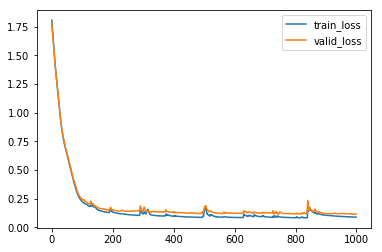

In [26]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

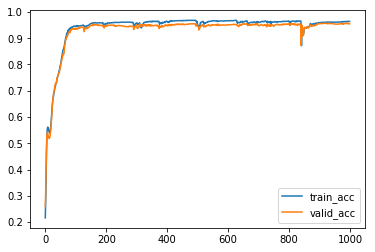

In [27]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [29]:
with tf.Session() as sess:
    # Restore the validated model
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    saver.restore(sess=sess, save_path='checkpoints/lstm-imu-har.ckpt')
    
    # Loop over batches of Test
    state = sess.run(initial_state)
    loss_batch, acc_batch = [], []
    for Xarr, Yarr in get_batches(X=Xtest, y=Ytest, batch_size=batch_size):

        # Feed dictionary
        feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
        lossarr, state, accarr = sess.run([loss, final_state, accuracy], feed_dict=feed_dict)
        loss_batch.append(lossarr)
        acc_batch.append(accarr)

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:.6f}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/lstm-imu-har.ckpt
Test loss: 0.453735 Test acc: 0.875340
